In [126]:
import createdb as cdb
import detectobjects as det
import convnet
import numpy as np
import subprocess
import seaborn as sns
import pylab as plt
%matplotlib inline

In [99]:
opts = {'img_dir': '../data/images/',
        'models_dir': '../models/',
        'annotation_dir': '../data/annotation/',
        'train-dir': '../data/train/',
        'test-dir': '../data/test/',
        'val-dir': '../data/val/',
        'augment-training-data': False,
        'model': '2C-1FC-O',
        'threshold': 0.1, 
        'overlapThreshold': 0.3, 
        'lim': 0, 
        'prob': det.MAX, 
        'pos': det.MAX, 
        'gauss': 1,
        'mean': np.array([162.83]),
        'input_scale': None,
        'raw_scale': 255,
        'image_dims': (50,50),
        'channel_swap': None,
        'probs_area': 40,
        'detection-step': 5,
        'patch-creation-step': 40,
       }

**Create data files**

In [131]:
reload(cdb)
trainfiles, valfiles, testfiles = cdb.create_sets(opts['img_dir'], train_set_proportion=.6, 
                                                  test_set_proportion=.2,
                                                  val_set_proportion=.2)

cdb.write_db(trainfiles, valfiles, testfiles, opts)

Creating training set
[****************100%******************]  302501 of 303457 complete 
Creating validation set
[*****************99%******************]  101501 of 102047 complete 
Creating test set
[*****************99%******************]  106001 of 106700 complete


**Detector training**

In [107]:
net = convnet.ConvNetClassifier(opts)
net.train()

../models/2C-1FC-O
I1020 12:25:21.591271 2062648080 solver.cpp:54] Initializing solver from parameters: 
test_iter: 45
test_interval: 100000
base_lr: 0.001
display: 100
max_iter: 100
lr_policy: "inv"
gamma: 0.0001
power: 0.75
momentum: 0.9
weight_decay: 0.0005
snapshot: 10000
snapshot_prefix: "malarianet_train"
solver_mode: CPU
net: "train_val.prototxt"
I1020 12:25:21.592231 2062648080 solver.cpp:96] Creating training net from net file: train_val.prototxt
I1020 12:25:21.592473 2062648080 net.cpp:339] The NetState phase (0) differed from the phase (1) specified by a rule in layer data
I1020 12:25:21.592494 2062648080 net.cpp:339] The NetState phase (0) differed from the phase (1) specified by a rule in layer accuracy
I1020 12:25:21.592501 2062648080 net.cpp:50] Initializing net from parameters: 
name: "CaffeNet"
state {
  phase: TRAIN
}
layer {
  name: "data"
  type: "Data"
  top: "data"
  top: "label"
  include {
    phase: TRAIN
  }
  transform_param {
    mirror: true
    crop_size: 

**Evaluate performance on test set**

In [117]:
reload(det)
found_objects = []
for i, f in zip(range(len(testfiles)), testfiles):
    print f
    imfile = opts['img_dir'] + f
    found_objects[f] = det.detect(imfile, net, opts)

0 plasmodium-1454.jpg
1 plasmodium-1650.jpg


KeyboardInterrupt: 

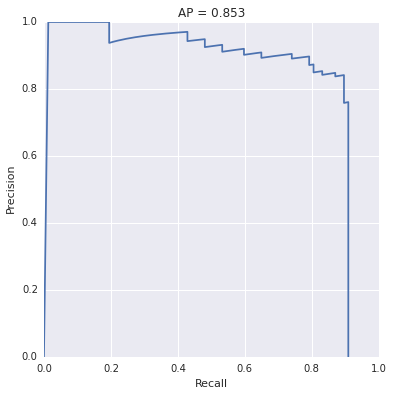

In [129]:
import evaluation as ev
found_dict = {}
found_dict[testfiles[0]] = found_objects[0]
rec, prec, p = ev.evaluate_detection(found_dict, opts['annotation_dir'],testfiles,0.15)
area = ev.compute_auc(rec, prec)        

current_palette = sns.color_palette()
fig,ax = plt.subplots()
fig.set_size_inches(6,6)        
sns.set_style("darkgrid")
plt.plot(np.hstack([0,rec,rec[-1]]),
            np.hstack([0,prec,0]) , color=current_palette[0])
plt.xlabel('Recall')
plt.ylabel('Precision')      
plt.grid(True)        
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title("AP = " + "{:0.3f}".format(area))